# Estimación de parámetros
_Juliana Vallejo Díez, Paola Andrea Fernández López, María Camila Vásquez Correa_

In [23]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [30]:
indexs = pd.read_excel('temp.xlsx')['fecha4']
temp = pd.read_excel('temp.xlsx')['sevilla47']

In [48]:
temp.index = indexs

In [56]:
X = np.array(temp)[:750]

In [57]:
X.shape

(750,)

## Procesos de reversión a la media con tendencia a largo plazo.

$$dX_t = \alpha(\mu(t) - X_t)dt + \sigma X_t^\gamma dB_t \qquad t\in[0,T] \qquad X_0 = x$$

* $\alpha>0$ es la tasa de reversión.
* $\mu(t)$ es una función determinista, el nivel medio de reversión.
* $\sigma > 0$ está asociado con la volatilidad.
* $\gamma \in [0, 3_/2]$ determina la sensibilidad de la varianza.

## Simulación
**Parámetros**

In [2]:
X0 = 2
alpha1 = 37
sigma1 = 0.7
gamma = 1
a = 1.5
b = 1
P = 1
beta = 2*np.pi/P
N = 500
dt = 1/250
t = np.arange(0, N)

**Función de tendencia**

In [3]:
def mu(t):
    return a + b*np.sin((2*np.pi*t)/P)

**Función media de $X_t$**

Para $\mu(t) = a + b\sin(2\pi t/P)$

In [4]:
m0 = mu(0)
def m(t):
    c = a + (m0 - a + (a*beta*b)/(a**2* + beta**2))*np.exp(-alpha1*t)
    d = ((a*b)/(a**2 + beta**2))*(alpha1*np.sin(beta*t) - beta*np.cos(beta*t))
    return c + d

**Simulación tendencia y media**

In [5]:
mu1 = np.zeros(N)
m1 = np.zeros(N)
for j in range(N):
    mu1[j] = mu(j*dt)
    m1[j] = m(j*dt)

**Simulación trayectoria**

In [6]:
X = np.zeros(N)
X[0] = X0
for j in range(1,N):
    X[j] = X[j-1] + alpha1*(mu1[j] - X[j-1])*dt + sigma1*X[j-1]**gamma*np.sqrt(dt)*np.random.normal()    

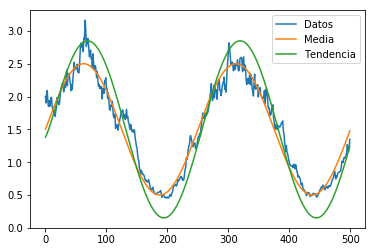

In [7]:
plt.plot(X, label='Datos')
plt.plot(mu1, label='Media')
plt.plot(m1, label='Tendencia')
plt.legend()
plt.show()

## Parámetros a estimar
$\theta = [\alpha, \sigma, \gamma]$

$$\mu(t) = m(t) + \frac{\dot{m}(t)}{\alpha}$$

_Derivada numérica_

In [58]:
def numDer(mi):
    mid = [(2*mi[i+1] - 3*mi[i] + mi[i-1])/dt for i in range(1,len(mi)-1)]
    mid.insert(0, (mi[1] - mi[0])/dt)
    mid.append((mi[-1] - mi[-2])/dt)
    return mid

_Primera estimación de $\alpha$_

In [59]:
def alpha(mi, mid):
    al1 = [X[i] - X[i-1] - mid[i-1]*dt for i in range(1,N)]
    al1 = [al1[i-1]*(mi[i-1] - X[i-1]) for i in range(1,N)]
    al1 = [al1[i-1]/X[i-1]**(2*gamma) for i in range(1,N)]
    al1 = np.sum(al1)
    al2 = [mi[i-1] -X[i-1] for i in range(1,N)]
    al2 = [al2[i-1]/X[i-1]**gamma for i in range(1,N)]
    al2 = [(al2[i-1]**2)*dt for i in range(1,N)]
    al2 = np.sum(al2)
    return al1/al2

_Primera estimación de $\sigma$_

In [60]:
def sigma(mi, mid, alpha):
    s1 = [X[i] - X[i-1] for i in range(1,N)]
    s2 = [(alpha*(mi[i-1] - X[i-1]) + mid[i-1])*dt for i in range(1,N)]
    s = [s1[i] - s2[i] for i in range(N-1)]
    s = [(s[i-1]/X[i-1]**gamma)**2 for i in range(1,N)]
    s = np.sum(s)
    s = np.sqrt((1/(N*dt))*s)
    return s    

_Filtro de Hodrick y Prescott_

$s$ es el parámetro de suavizado

In [65]:
import statsmodels.api as sm
s = 62500
cycle, trend = sm.tsa.filters.hpfilter(X,s)

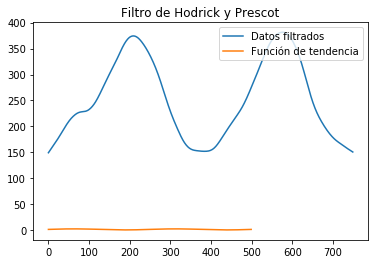

In [67]:
plt.plot(trend, label='Datos filtrados')
plt.plot(mu1, label='Función de tendencia')
plt.legend(loc=1)
plt.title('Filtro de Hodrick y Prescot')
plt.show()

_Primera estimación de parámetros_

In [13]:
mid = numDer(trend)
alphae2 = alpha(trend, mid)
sigmae = sigma(trend, mid, alphae2)
print('alpha: ', alphae2)
print('sigma: ', sigmae)

alpha:  36.12196797544108
sigma:  0.6780351465018192


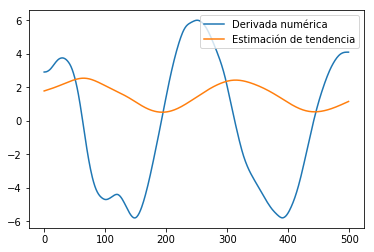

In [14]:
plt.plot(mid, label='Derivada numérica')
plt.plot(trend, label='Estimación de tendencia')
plt.legend(loc=1)
plt.show()

_Primera estimación de $\mu$_

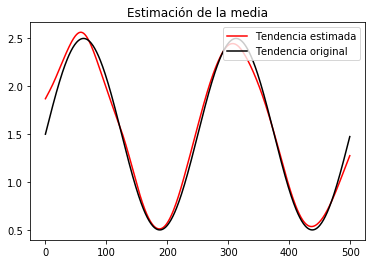

In [15]:
mut = [trend[i] + mid[i]/alphae2 for i in range(N)]
plt.plot(mut, 'red', label='Tendencia estimada')
plt.plot(mu1, 'black', label='Tendencia original')
plt.title('Estimación de la media')
plt.legend(loc=1)
plt.show()

### Reestimación

_Ajuste de la función de tendencia_

Se hace un ajuste basado en estimación de mínimos cuadrados a una función seno, pueden añadirse más.

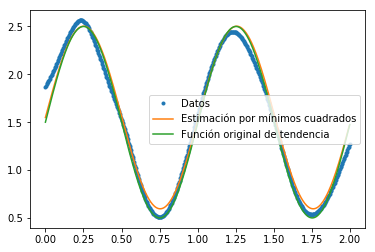

In [16]:
from scipy.optimize import leastsq

data = mut
t = np.linspace(0, N*dt, num=N)

guess_bias = np.mean(data)
guess_freq = 1
guess_amp = 1

optimize_func = lambda x: (x[0] + x[1]*np.sin(2*np.pi*t/x[2]) - data)**2
est_bias, est_freq, est_amp = leastsq(optimize_func, [guess_bias, guess_freq, guess_amp])[0]

fine_t = np.arange(0,max(t),dt)
data_fit=est_bias + est_freq*np.sin(2*np.pi*fine_t/est_amp)

plt.plot(t,data, '.', label='Datos')
plt.plot(fine_t, data_fit, label='Estimación por mínimos cuadrados')
plt.plot(t,mu1, label='Función original de tendencia')
plt.legend()
plt.show()

_Segunda estimación de $\alpha$_

In [17]:
def alphae(muest):
    a1 = [(X[i] - X[i-1])*(muest[i-1] - X[i-1]) for i in range(1,N)]
    a1 = [a1[i-1]/(X[i-1]**(2*gamma)) for i in range(1,N)]
    a1 = np.sum(a1)
    a2 = [(((muest[i-1] - X[i-1])/X[i-1]**gamma)**2)*dt for i in range(1,N)]
    a2 = np.sum(a2)
    return a1/a2

_Segunda estimación de $\sigma$_

In [18]:
def sigmae(muest, alphae11):
    s1 = [X[i] - X[i-1] for i in range(1,N)]
    s2 = [(alphae11*(muest[i-1] - X[i-1]))*dt for i in range(1,N)]
    s = [s1[i] - s2[i] for i in range(N-1)]
    s = [(s[i-1]/X[i-1]**gamma)**2 for i in range(1,N)]
    s = np.sum(s)
    s = np.sqrt((1/(N*dt))*s)
    return s 

**Reestimación**

In [19]:
muest = data_fit
alphae2 = alphae(muest)
sigmae2 = sigmae(muest, alphae2)
print('alpha', alphae2)
print('sigma', sigmae2)

alpha 26.035206906316276
sigma 0.7058361219267082


In [20]:
k = 100
X1 = np.zeros((k,N))
X1[:, 0] = X0
for i in range(k):
    for j in range(1,N):
        X1[i,j] = X[j-1] + alphae2*(muest[j-1] - X[j-1])*dt + sigmae2*X[j-1]*np.sqrt(dt)*np.random.normal() 

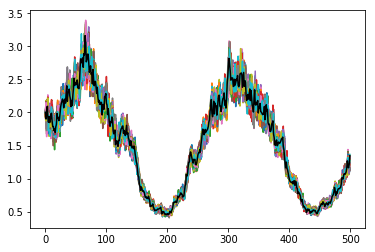

In [22]:
plt.plot(X1.T)
plt.plot(X, 'black')
plt.show()